Số quan sát: 40
Train samples: 30
Test samples : 5
Huấn luyện RNN hoàn tất
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step

===== ĐÁNH GIÁ RNN (GDP) =====
MAE  = 14,511,524,207 USD
RMSE = 18,753,470,089 USD
R²   = 0.8382


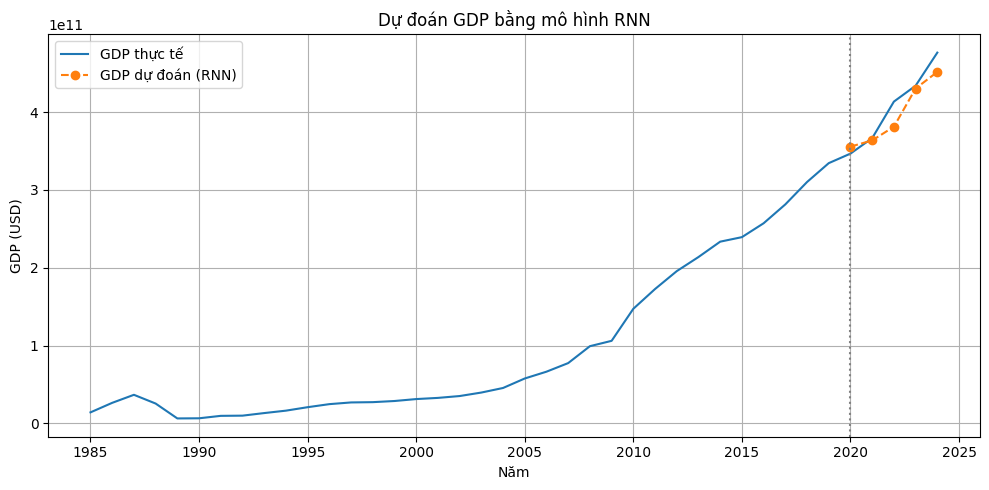

In [8]:
# ===== RNN (SimpleRNN) DỰ ĐOÁN GDP =====

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 1. LOAD DATA
df = pd.read_csv("macro_vietnam_processed.csv")

df = df.sort_values("Year").reset_index(drop=True)
gdp = df["GDP"].values.reshape(-1, 1)

print("Số quan sát:", len(gdp))

# 2. CHUẨN HÓA
scaler = MinMaxScaler()
gdp_scaled = scaler.fit_transform(gdp)

# 3. TẠO SEQUENCE
def create_sequences(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

window_size = 5   # RNN học ngắn hạn tốt
X, y = create_sequences(gdp_scaled, window_size)

# 4. TRAIN / TEST SPLIT (GIẤU 5 NĂM CUỐI)
n_test = 5
X_train, X_test = X[:-n_test], X[-n_test:]
y_train, y_test = y[:-n_test], y[-n_test:]

years_test = df["Year"].iloc[window_size + len(X_train):]

print("Train samples:", X_train.shape[0])
print("Test samples :", X_test.shape[0])

# 5. XÂY DỰNG MÔ HÌNH RNN
model = Sequential([
    Input(shape=(window_size, 1)),
    SimpleRNN(32, activation="tanh"),
    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=0.005),
    loss="mse"
)

# 6. HUẤN LUYỆN
early_stop = EarlyStopping(
    monitor="loss",
    patience=20,
    restore_best_weights=True
)

model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=4,
    callbacks=[early_stop],
    verbose=0
)

print("Huấn luyện RNN hoàn tất")

# 7. DỰ ĐOÁN & ĐÁNH GIÁ
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_real = scaler.inverse_transform(y_test)

mae  = mean_absolute_error(y_test_real, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred))
r2   = r2_score(y_test_real, y_pred)

print("\n===== ĐÁNH GIÁ RNN (GDP) =====")
print(f"MAE  = {mae:,.0f} USD")
print(f"RMSE = {rmse:,.0f} USD")
print(f"R²   = {r2:.4f}")

# 8. BIỂU ĐỒ
plt.figure(figsize=(10,5))
plt.plot(df["Year"], gdp, label="GDP thực tế")
plt.plot(years_test, y_pred, 
         linestyle="--", marker="o", label="GDP dự đoán (RNN)")
plt.axvline(years_test.iloc[0], color="gray", linestyle=":")
plt.xlabel("Năm")
plt.ylabel("GDP (USD)")
plt.title("Dự đoán GDP bằng mô hình RNN")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
